In [1]:
import numpy as np
import cv2 as cv
from PIL import Image
from src import *
import matplotlib.pyplot as plt
import pandas as pd
import skimage


# Calibration

In [2]:
img = Image.open('./data/CALIB_ALEX_VEIKKA.png')
points = select_points(img)

# points = np.array([[498, 673],
    #    [398, 294],
    #    [463, 357],
    #    [594, 361],
    #    [664, 429],
    #    [735, 534],
    #    [812, 611],
    #    [756, 281],
    #    [932, 587]])

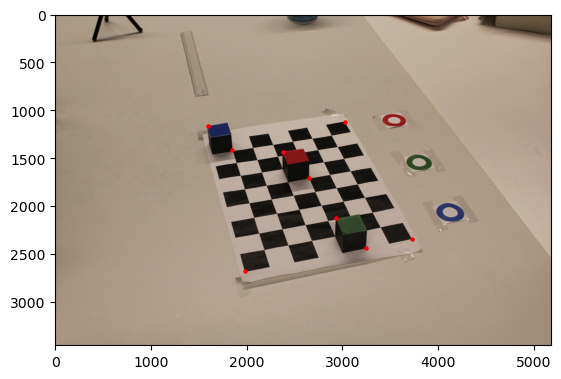

In [3]:
pts = points.copy()
plt.imshow(img)
plt.scatter(*pts.T, s=5, c='r')

In [4]:
points3 = pd.read_csv('./data/3d_points.csv', index_col=0)
points3 = points3.iloc[:, -3:].to_numpy()

M = calibrate_norm(points, points3)

In [5]:
intrinsic, extrinsic = extract_params(M)

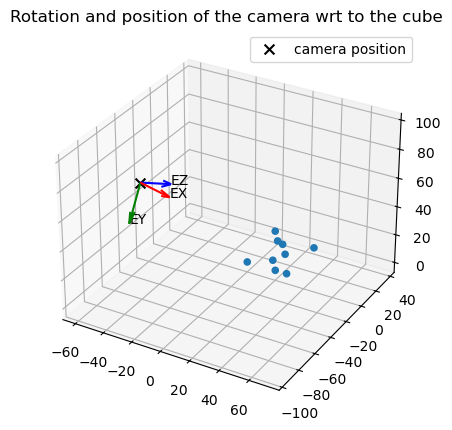

In [6]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(projection='3d')
ax.set_title("Rotation and position of the camera wrt to the cube")
ax.grid(True)
ax.scatter(*points3.T, alpha=1)
plot_frame(extrinsic, ax, name="E", l=25, s=50)

plt.legend()
plt.axis('equal')
plt.show()



# Robot detection

## Idea:

- threshold colors using HSV images
- find areas and their coordinates
- transform into world coordinates:
$
    \begin{bmatrix} X \\ Y \\ W \end{bmatrix} = 
    M_{\{1,2,4\}}^{-1} \left(
    \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} - M_{\{3\}} Z
    \right),
$
- $M$ and $Z$ is known
- $X = \frac{X}{W}$, $Y=\frac{Y}{W}$
- find center of mass from $X$ and $Y$ $\rightarrow$ object location

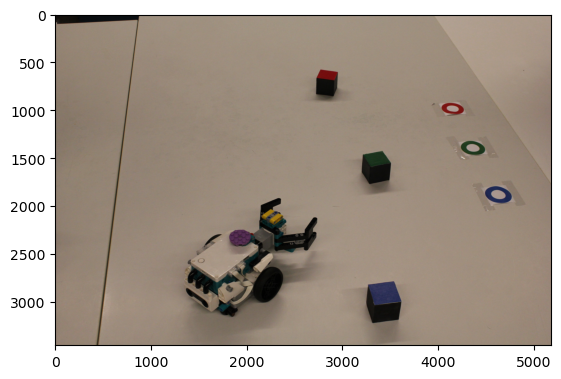

In [10]:
test = Image.open('./data/set2/images/image0002.png')
test = np.array(test)
# test = Image.open('./data/showcase/bot.png')
plt.imshow(test)

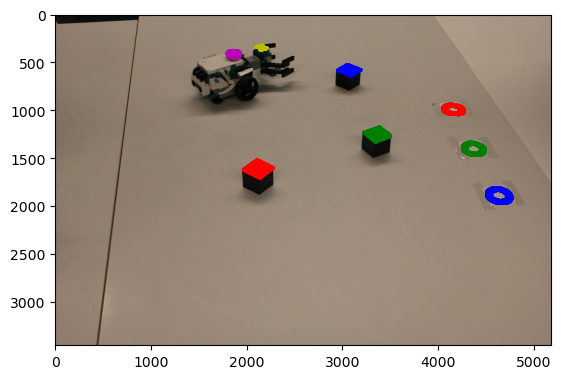

In [14]:
test = Image.open('./data/set2/images/image0003.png')
# test = Image.open('./data/showcase/all.png')

centroids = locate_bot(test)

disk, bar1, bar2 = centroids

plt.imshow(test, cmap='gray')
# plt.scatter(*centroids.T, c='r', s=2, marker='.')
plt.scatter(*disk.T, c='m', s=.1, marker='.')
plt.scatter(*bar1.T, c='y', s=.1, marker='.')
plt.scatter(*bar2.T, c='y', s=.1, marker='.')

out = locate_rest(test)
red, green, blue = out

for col, c in zip(out, ('r', 'g', 'b')):
    cube, goal = col
    plt.scatter(*cube.T, c=c, s=0.1)
    plt.scatter(*goal.T, c=c, s=0.1)

0


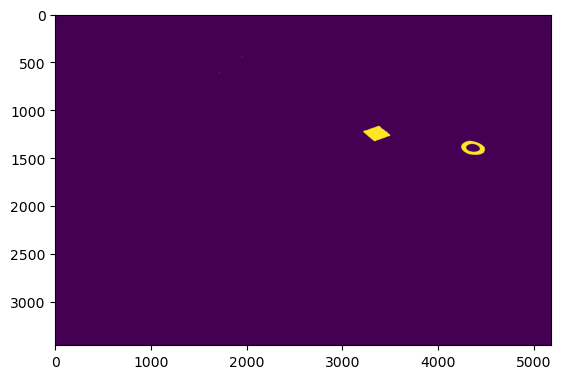

In [ ]:
hsv = cv.cvtColor(np.array(test), cv.COLOR_RGB2HSV)

green = cv.inRange(hsv, (40, 30, 30), (70, 255, 245))

opened = cv.morphologyEx(green, cv.MORPH_OPEN, np.ones((5, 5)))
closed = cv.morphologyEx(opened, cv.MORPH_CLOSE, np.ones((11, 11)))

labels = skimage.measure.label(closed)
regions = skimage.measure.regionprops(labels)

areas = [r.area for r in regions]
idx = np.argsort(areas)[::-1]

regions = [regions[i] for i in idx[:2]]

y, x = map(int, regions[1].centroid)
print(closed[y, x])

plt.imshow(closed)


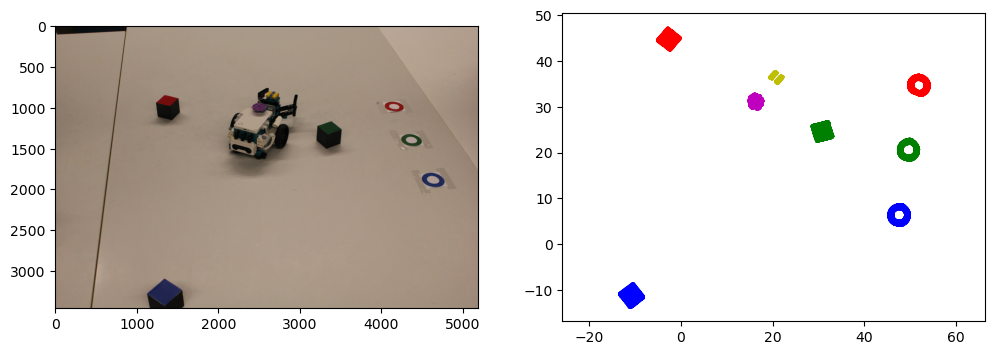

In [21]:
test = Image.open('./data/set2/images/image0005.png')

centroids = locate_bot(test)

disk, bar1, bar2 = centroids

out = locate_rest(test)
red, green, blue = out

A = np.linalg.inv(M[:, [0, 1, 3]])
b = M[:, 2:3]

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(test)

for points, z, c in zip((disk, bar1, bar2, *red, *green, *blue),
                     (7.7, 7.0, 7.0, 4, 0, 4, 0, 4, 0),
                     ('m', 'y', 'y', 'r', 'r', 'g', 'g', 'b', 'b')):
    n = len(points)
    points = np.concat((points.T, [[1] * n]), 0)
    out = A @ (points - z * b)
    x, y = out[:-1] / out[-1]
    ax2.scatter(x, y, c=c, marker='.', s=0.1)

plt.axis('equal')
plt.show()
